In [3]:
from PIL import Image
import numpy as np

file_path = '/media/veering/veering_dl_stora/stripeField_devPics/P1230037.JPG' # defien file path
im = Image.open(file_path) # import pictuate as Pillow Image object
pix = np.array(im) # convert to Numpy aray
h, w, d = orig_shape = tuple(pix.shape) # store original shape of array
pix_flat = np.reshape(pix, (h*w, d)) # flatten image for clustering
print(file_path)

/media/veering/veering_dl_stora/stripeField_devPics/P1230037.JPG


In [4]:
## initiate sklearnex
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.cluster import KMeans # import K means
import matplotlib.pyplot as plt

no_clusters = 5 # start clustering from 5 clusters
clusterMin = 1 # set cluster min at 1 to enter while loop
while clusterMin > 0.01: # continue to increase number of clusters until the smallest cluster becomes suficently small to just be stripes
    print(no_clusters)
    kmeans = KMeans(n_clusters = no_clusters) # define cluster object
    cluster = kmeans.fit(pix_flat) # find clusters
    labels = cluster.labels_ # save cluster labels as a list
    percent = np.unique(labels, return_counts=True) # get counts # pixels in each cluster
    stripeColour = np.where(percent[1] == min(percent[1])) # return label of least frequent pixel
    clusterMin = min(percent[1]) / (h*w) # find fraction of picture occupied by smallest cluster
    print(clusterMin)
    no_clusters += 1 # increase cluster counter by 1

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


5
0.05524766666666667
6
0.05293383333333333
7
0.009585583333333333


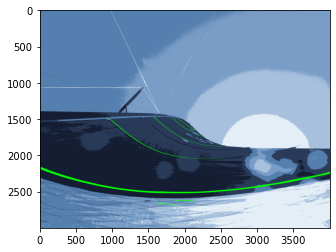

In [5]:
kmeans_image = cluster.cluster_centers_ # save cluster centres to plot image to check clusters
kmeans_image[stripeColour] = np.asarray([0,255,0]) # change the stripe cluster centre to lime green
kmeans_image = cluster.cluster_centers_[cluster.labels_] # assign each pixcel itc cluster colour
kmeans_image = np.reshape(kmeans_image, orig_shape) # reshape array for plotting
plt.imshow(kmeans_image.astype('uint8')) # plot image
plt.show()


In [6]:
vert_ex = 1
labels = np.reshape(labels,(h,w)) # reshape labels array in 2d array (like picture)
stripes = np.where(labels == stripeColour) # get coordinates of all pixels which are a stripe colour
stripes = np.asarray(stripes) # build 2d array of stripe coordinates for clustering
stripes = np.transpose(stripes) # transpose array so as cordinates are pairs
stripes_Vexagerated = np.copy(stripes) # move coordinates into V-Exagerate
stripes_Vexagerated[:,0] = stripes_Vexagerated[:,0] * vert_ex # apply vertical exageration

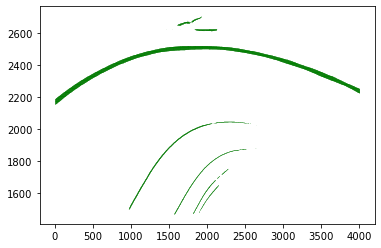

In [7]:
plt.plot(stripes_Vexagerated[:,1], stripes_Vexagerated[:,0], 'o', markersize=0.01, color='green') # create scatter plot of vertical exagerated stripes

In [8]:
stripes_single = np.copy(stripes[np.lexsort((stripes[:,0], stripes[:,1]))]) # sort stripes array by column values and then the row values
start_stop = np.where(np.diff(stripes_single[:,0], axis=0) != 1) # return index of locations where the difference between elements is not 1
start_stop = list(start_stop[0]) # convert start_stop to list
start_stop.insert(0,0) # insert a leading zero to mark start of first stripe
new_cols = np.where(np.diff(stripes_single[:,1], axis=0) == 1) # idetify indecies of start stop the corespond to new columns
new_cols = list(new_cols[0]) # convert new_cols to list so as it can be used to index array
new_cols.insert(0,0) # add leading zero
final_ind = [] # emty list to append stripe indecies on
for i in range(len(new_cols)-1): # iterate over all of the new columns
    col_starts = start_stop.index(new_cols[i]) # get the index of the startiung value
    col_ends = start_stop.index(new_cols[i+1]) # get the index of the finishing value
    if col_ends - col_starts == 1: # chewck if there other other indeces between the start and finish of the column
        centre_index = int((start_stop[col_ends] + start_stop[col_starts]) / 2) # if no intermediate calculate centre as average of the start and end of column
        final_ind.append(centre_index) # append to final ind

    else: # if other indeces are present
        sub_start_stop = start_stop[col_starts:col_ends+1] # create sub start stop as all indeces in given column of image
        sub_start_stop[0] = sub_start_stop[0]+1 # increase index of first value by one as start stop contains the last index of each block of "stripe colour"
        toDrop = [] # create empty list of indeces to drop
        for j in range(1,(len(sub_start_stop)-1)): # iterate over each value in sub start stop
            if (stripes_single[sub_start_stop[j]+1,0] - stripes_single[sub_start_stop[j], 0]) < 6: # check if the block only occurs due to a small gab pf "stripe colour"
                if j != 0 or j != len(sub_start_stop)-1: # if the value isn't the first or last value in the sub_start_stop
                    toDrop.append(j) # append to "toDrop
        val_to_drop = [sub_start_stop[drop] for drop in toDrop] # iterate over toZdrop and get values to be dropped
        [sub_start_stop.remove(val) for val in val_to_drop] # iterate over values to drop and drop from sub start stop
        centre_index = [int(sum(sub_start_stop[m:m+2])/2) for m in range(len(sub_start_stop)-1)] # iterate over remaing sub_start_stop and calculate the centre of each block and save index
        [final_ind.append(index) for index in centre_index] # iterate over index and append to index final
final_ind.sort() # sort final indicies for completeness
stripes_single = np.copy(stripes_single[final_ind,:]) # recreate stripes single using only the indices found.

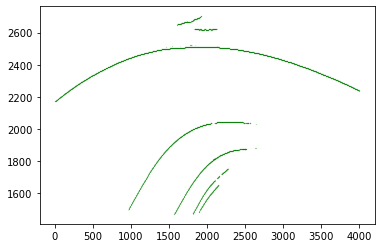

In [9]:
plt.plot(stripes_single[:,1], stripes_single[:,0], 'o', markersize=0.05, color='green') # create scatter plot of vertical exagerated stripes


In [10]:
assesment_array = np.empty([h,w]) # make empty array to build an array to asses if each vertical has all unique values
assesment_array[:] = np.nan
for i in range(len(stripes_single[:,0])): # iterate over all stripe coridnates
    n = stripes_single[i,0] # assign n the row number of the stripe
    n = int(n/vert_ex)
    m = stripes_single[i,1] # assign m the column number of the stripe
    x = np.where(stripes[:,0] == n)
    y = np.where(stripes[:,1] == m)
    lab_ind = np.intersect1d(x,y)

repeated_cluster = np.where(np.diff(np.sort(assesment_array, axis=0), axis=0) == 0) # check if columns have multiple pixcels in them
repeated_cluster_tolerance = len(repeated_cluster[0]) # record nu,ber of repated pixcels to use as a tollerence for dbscan clustering

In [11]:
from sklearn.cluster import DBSCAN # import DB Scan
distance = [] # set inital eps (distance to jump in clustering) to 25
repeated_cluster = True # set to true to enter while loop
loss = []
for d in range(5,65,5):
    print(d)
    stripe_clusters = DBSCAN(eps=d, min_samples=10).fit(stripes_Vexagerated) # fit clusters using DB SCAN

    assesment_array = np.empty([h,w]) # make empty array to build an array to asses if each vertical has all unique values
    assesment_array[:] = np.nan
    for i in range(len(stripes_single[:,0])): # iterate over all stripe coridnates
        n = stripes_single[i,0] # assign n the row number of the stripe
        n = int(n/vert_ex)
        m = stripes_single[i,1] # assign m the column number of the stripe
        x = np.where(stripes[:,0] == n)
        y = np.where(stripes[:,1] == m)
        lab_ind = np.intersect1d(x,y)
        if stripe_clusters.labels_[lab_ind] != -1: # dont assing lable to outliers
            assesment_array[n,m] = stripe_clusters.labels_[lab_ind] # assign the label

    repeated_cluster = np.where(np.diff(np.sort(assesment_array, axis=0), axis=0) == 0) # check if columns have alot of the same cluster
    repeated_cluster = len(repeated_cluster[0]) # if no more than 10 repeated clusters break while loop
    no_clus = len(np.unique(stripe_clusters.labels_))
    l = repeated_cluster * no_clus
    print(loss)
    distance.append(d)
    loss.append(l)

cluster_distance = min(loss)
cluster_distance = loss.index(cluster_distance)
cluster_distance = distance[cluster_distance]

stripe_clusters = DBSCAN(eps=cluster_distance, min_samples=10).fit(stripes_Vexagerated) # fit clusters using DB SCAN

5
[]
10
[1020]
15
[1020, 720]
20
[1020, 720, 660]
25
[1020, 720, 660, 600]
30
[1020, 720, 660, 600, 540]
35
[1020, 720, 660, 600, 540, 480]
40
[1020, 720, 660, 600, 540, 480, 480]
45
[1020, 720, 660, 600, 540, 480, 480, 2058]
50
[1020, 720, 660, 600, 540, 480, 480, 2058, 2058]
55
[1020, 720, 660, 600, 540, 480, 480, 2058, 2058, 2298]
60
[1020, 720, 660, 600, 540, 480, 480, 2058, 2058, 2298, 2298]


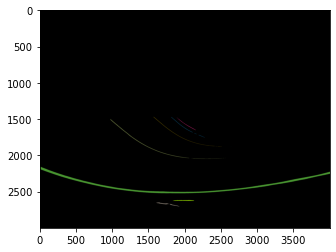

In [12]:
colours = [] # empty list to build colour for each cluster in
counter = 0
while counter < len(np.unique(stripe_clusters.labels_)): # build enough colour for each cluster
    colours.append(np.random.choice(range(256), size = 3)) # make random colour
    counter += 1
colours = np.array(colours) # convert colours to array
colours = colours[stripe_clusters.labels_] # assign colours to each test stripe

assesment_image = np.empty(orig_shape) # make empty array to build image of stripe clusters in
for i in range(len(stripes_Vexagerated[:,0])): # iterate over all stripe coridnates
    n = stripes_Vexagerated[i,0] # assign n the row number of the stripe
    n = int(n/vert_ex) # remove vertical exageration
    m = stripes_Vexagerated[i,1] # assign m the column number of the stripe
    assesment_image[n,m] = colours[i,:] # assign the label

plt.imshow(assesment_image.astype('uint8')) # plot image
plt.imsave('stripes.png', assesment_image.astype('uint8'))

In [13]:

cluster_Grads = {} # create empty dictionary to store gradient and average height of each cluster
outlier_ind = []
for lab in np.unique(stripe_clusters.labels_): # iterate over each label
    if lab != -1: # only asses if not already identified as an outlier
        location = np.where(stripe_clusters.labels_ == lab) # return location of stripes with label "lab in stripes array
        x = stripes[location,1][0] # return x value of stripe
        y = stripes[location, 0][0] # return y vlaue of stripe
        m,b = np.polyfit(x,y,1) # find gradient and intercept
        height = sum(x)/len(x) # record average height of cluster
        volume = len(x)
        position = sum(y)/len(y)
        horizontal_density = len(np.unique(x))/len(np.unique(y))
        cluster_Grads[lab] = [m, horizontal_density] # store gradient and height in dictionary
outlier_data = list(cluster_Grads.values()) # get dict values
outlier_data = np.asarray(outlier_data) # convert to array


In [14]:
## determine if most common gradient and density then remove those that are not

gradient = list(outlier_data[:,0]) # return list of all cluster gradients
grad_sign_pos = sum(map(lambda x : x > 0, gradient))/len(gradient) > 0.5 # return logical true if a majority of gradients are positive

density = list(outlier_data[:,1]) # retrun list of horizontal densities
density_mag_1 = sum(map(lambda x : x > 0.99, density))/len(density) > 0.5 # retrun logical true if a majority of densities are  > 1

stripe_clusters_labs_cleaned = np.copy(stripe_clusters.labels_) # create new copy of dbscan labels

# sort through all combinations of gradient and density and apply correct logic and return list of inlying clusters

if grad_sign_pos and density_mag_1:
    grad_in = [grad > 0 for grad in gradient]
    mag_in = [mag > 1 for mag in density]
    inliers = [a and b for a,b in zip(grad_in, mag_in)]

elif grad_sign_pos and not density_mag_1:
    grad_in = [grad > 0 for grad in gradient]
    mag_in = [mag < 1 for mag in density]
    inliers = [a and b for a,b in zip(grad_in, mag_in)]

elif density_mag_1 and not grad_sign_pos:
    grad_in = [grad < 0 for grad in gradient]
    mag_in = [mag > 1 for mag in density]
    inliers = [a and b for a,b in zip(grad_in, mag_in)]

else:
    grad_in = [grad < 0 for grad in gradient]
    mag_in = [mag < 1 for mag in density]
    inliers = [a and b for a,b in zip(grad_in, mag_in)]

outliers = [i for i,x in enumerate(inliers) if not x] # return outlying clusters #

for out in outliers: # iterate over each outlier and change cluster label to -1
    change = np.where(stripe_clusters_labs_cleaned == out)
    for ind in list(change[0]):
        stripe_clusters_labs_cleaned[ind] = -1



In [15]:
stripes_removed = np.where(stripe_clusters_labs_cleaned == -1) # create a list of the indeces to be removed
stripes_removed = list(stripes_removed[0])
stripes_cleaned = np.where(stripe_clusters_labs_cleaned != -1) # create list of the indecies to be retained
stripes_cleaned = list(stripes_cleaned[0])

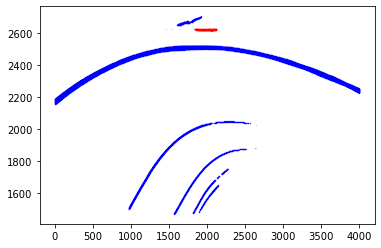

In [16]:
plt.plot(stripes[stripes_removed,1], stripes[stripes_removed,0], 'o', markersize = 0.05, color = 'red')
plt.plot(stripes[stripes_cleaned,1], stripes[stripes_cleaned,0], 'o', markersize = 0.05, color = 'blue')

In [17]:
stripes_cleaned = np.copy(stripes[stripes_cleaned,:]) # create array containing the row and column of each stripe pixcel

In [18]:

stripes_single_clean = np.copy(stripes_cleaned[np.lexsort((stripes_cleaned[:,0], stripes_cleaned[:,1]))]) # sort stripes array by column values and then the row values
start_stop = np.where(np.diff(stripes_single_clean[:,0], axis=0) != 1) # return index of locations where the difference between elements is not 1
start_stop = list(start_stop[0]) # convert start_stop to list
start_stop.insert(0,0) # insert a leading zero to mark start of first stripe
new_cols = np.where(np.diff(stripes_single_clean[:,1], axis=0) == 1) # idetify indecies of start stop the corespond to new columns
new_cols = list(new_cols[0]) # convert new_cols to list so as it can be used to index array
new_cols.insert(0,0) # add leading zero
final_ind = [] # emty list to append stripe indecies on
for i in range(len(new_cols)-1): # iterate over all of the new columns
    col_starts = start_stop.index(new_cols[i]) # get the index of the startiung value
    col_ends = start_stop.index(new_cols[i+1]) # get the index of the finishing value
    if col_ends - col_starts == 1: # chewck if there other other indeces between the start and finish of the column
        centre_index = int((start_stop[col_ends] + start_stop[col_starts]) / 2) # if no intermediate calculate centre as average of the start and end of column
        final_ind.append(centre_index) # append to final ind

    else: # if other indeces are present
        sub_start_stop = start_stop[col_starts:col_ends+1] # create sub start stop as all indeces in given column of image
        sub_start_stop[0] = sub_start_stop[0]+1 # increase index of first value by one as start stop contains the last index of each block of "stripe colour"
        toDrop = [] # create empty list of indeces to drop
        for j in range(1,(len(sub_start_stop)-1)): # iterate over each value in sub start stop
            if (stripes_single_clean[sub_start_stop[j]+1,0] - stripes_single_clean[sub_start_stop[j], 0]) < 20: # check if the block only occurs due to a small gab pf "stripe colour"
                if j != 0 or j != len(sub_start_stop)-1: # if the value isn't the first or last value in the sub_start_stop
                    toDrop.append(j) # append to "toDrop"
        val_to_drop = [sub_start_stop[drop] for drop in toDrop] # iterate over toZdrop and get values to be dropped
        [sub_start_stop.remove(val) for val in val_to_drop] # iterate over values to drop and drop from sub start stop
        centre_index = [int(sum(sub_start_stop[m:m+2])/2) for m in range(len(sub_start_stop)-1)] # iterate over remaing sub_start_stop and calculate the centre of each block and save index
        [final_ind.append(index) for index in centre_index] # iterate over index and append to index final
final_ind.sort() # sort final indicies for completeness
stripes_single_clean = np.copy(stripes_single_clean[final_ind,:]) # recreate stripes single using only the indices found.

In [19]:
## repeat dbscan
distance = [] # set inital eps (distance to jump in clustering) to 25
repeated_cluster = True # set to true to enter while loop
loss = []
for d in range(5,65,5):
    print(d)
    stripe_clusters = DBSCAN(eps=d, min_samples=10).fit(stripes_cleaned) # fit clusters using DB SCAN

    assesment_array = np.empty([h,w]) # make empty array to build an array to asses if each vertical has all unique values
    assesment_array[:] = np.nan
    for i in range(len(stripes_single_clean[:,0])): # iterate over all stripe coridnates
        n = stripes_single_clean[i,0] # assign n the row number of the stripe
        n = int(n/vert_ex)
        m = stripes_single_clean[i,1] # assign m the column number of the stripe
        x = np.where(stripes_cleaned[:,0] == n)
        y = np.where(stripes_cleaned[:,1] == m)
        lab_ind = np.intersect1d(x,y)
        if stripe_clusters.labels_[lab_ind] != -1: # dont assing lable to outliers
            assesment_array[n,m] = stripe_clusters.labels_[lab_ind] # assign the label
    repeated_cluster = np.where(np.diff(np.sort(assesment_array, axis=0), axis=0) == 0) # check if columns have alot of the same cluster
    repeated_cluster = len(repeated_cluster[0]) # if no more than 10 repeated clusters break while loop
    no_clus = len(np.unique(stripe_clusters.labels_))
    l = repeated_cluster * no_clus * repeated_cluster
    print(loss)
    distance.append(d)
    loss.append(l)

cluster_distance = min(loss)
cluster_distance = loss.index(cluster_distance)
cluster_distance = distance[cluster_distance]

stripe_clusters = DBSCAN(eps=cluster_distance, min_samples=10).fit(stripes_cleaned) # fit clusters using DB SCAN

5
[]
10
[40000]
15
[40000, 27500]
20
[40000, 27500, 25000]
25
[40000, 27500, 25000, 22500]
30
[40000, 27500, 25000, 22500, 17500]
35
[40000, 27500, 25000, 22500, 17500, 15000]
40
[40000, 27500, 25000, 22500, 17500, 15000, 15000]
45
[40000, 27500, 25000, 22500, 17500, 15000, 15000, 403280]
50
[40000, 27500, 25000, 22500, 17500, 15000, 15000, 403280, 403280]
55
[40000, 27500, 25000, 22500, 17500, 15000, 15000, 403280, 403280, 403280]
60
[40000, 27500, 25000, 22500, 17500, 15000, 15000, 403280, 403280, 403280, 403280]


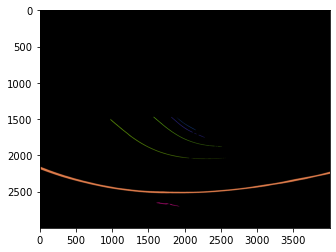

In [20]:
colours = [] # empty list to build colour for each cluster in
counter = 0
while counter < len(np.unique(stripe_clusters.labels_)): # build enough colour for each cluster
    colours.append(np.random.choice(range(256), size = 3)) # make random colour
    counter += 1
colours = np.array(colours) # convert colours to array
colours = colours[stripe_clusters.labels_] # assign colours to each test stripe

assesment_image = np.empty(orig_shape) # make empty array to build image of stripe clusters in
for i in range(len(stripes_cleaned[:,0])): # iterate over all stripe coridnates
    n = stripes_cleaned[i,0] # assign n the row number of the stripe
    n = int(n/vert_ex) # remove vertical exageration
    m = stripes_cleaned[i,1] # assign m the column number of the stripe
    assesment_image[n,m] = colours[i,:] # assign the label

plt.imshow(assesment_image.astype('uint8')) # plot image
plt.imsave('stripes.png', assesment_image.astype('uint8'))